In [4]:
!pip install -r requirements.txt -U

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 7.2 MB/s eta 0:00:0000:0100:01


In [1]:
import os
from ipyfilechooser import FileChooser

fc = FileChooser(os.path.join(os.getcwd(), '..', 'SPICE'))
fc.filter_pattern = '*.raw'
display(fc)

FileChooser(path='/mnt/c/Users/Aaron/Documents/class-d-amp/SPICE', filename='', title='', show_hidden=False, s…

Exception ignored in: Traceback (most recent call last):
'cupy.cuda.texture.CUDAarray.__dealloc__'
Traceback (most recent call last):
  File "cupy_backends/cuda/api/runtime.pyx", line 561, in cupy_backends.cuda.api.runtime.freeArray
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_7216/3640541573.py", line 157, in <module>
    for phase_res in cp.degrees(cp.angle(res)):
  File "/home/aaron/.local/lib/python3.10/site-packages/cupy/_math/arithmetic.py", line 73, in angle
    return _core.angle(z)
  File "cupy/_core/_kernel.pyx", line 1372, in cupy._core._kernel.ufunc.__call__
  File "cupy/_core/_kernel.pyx", line 1399, in cupy._core._kernel.ufunc._get_ufunc_kernel
  File "cupy/_core/_kernel.pyx", line 1082, in cupy._core._kernel._get_ufunc_kernel
  File "cupy/_core/_kernel.pyx", line 94, in cupy._core._kernel._get_simple_elementwise_kernel
  File "cupy/_co

CUDADriverError: CUDA_ERROR_LAUNCH_FAILED: unspecified launch failure

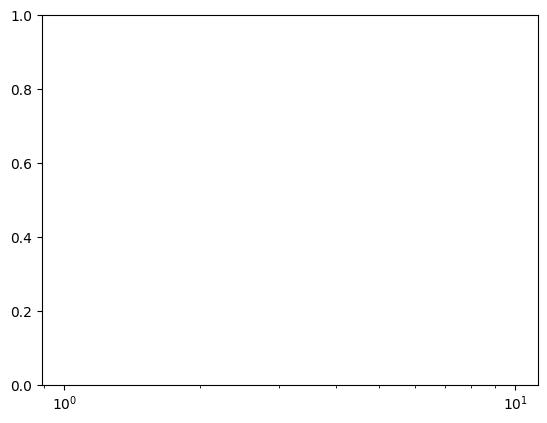

In [3]:
import ltspice
import numpy as np

lt = ltspice.Ltspice(fc.selected)
lt.parse()

for case in range(lt.case_count):
    raw_freq = lt.get_frequency(case)
    raw_res = lt.get_data('v(fb)', case)

    cf_desc = cp.cuda.texture.ChannelFormatDescriptor(
        32, 32, 0, 0, cp.cuda.runtime.cudaChannelFormatKindFloat
    )
    
    arr = cp.cuda.texture.CUDAarray(
        cf_desc, len(raw_freq), flags=cp.cuda.runtime.cudaArrayDefault
    )

    c = np.empty(2 * len(raw_res), dtype=np.float32)
    c[0::2] = np.real(raw_res)
    c[1::2] = np.imag(raw_res)

    arr.copy_from(c)

    res_desc = cp.cuda.texture.ResourceDescriptor(
        cp.cuda.runtime.cudaResourceTypeArray,
        cuArr=arr
    )

    tex_desc = cp.cuda.texture.TextureDescriptor(
        (cp.cuda.runtime.cudaAddressModeBorder,),
        cp.cuda.runtime.cudaFilterModeLinear,
        cp.cuda.runtime.cudaReadModeElementType,
        normalizedCoords=True
    )

    tex = cp.cuda.texture.TextureObject(res_desc, tex_desc)

    h_size = 32
    f_size = 8192
    n_size = 8192

    phase_kernel = cp.RawKernel(
        fr'''
        #define TEX_OFFSET {-np.log10(raw_freq[0])}
        #define TEX_SCALE {1 / (np.log10(raw_freq[-1]) - np.log10(raw_freq[0]))}
        #define H_SIZE {h_size}
        #define F_SIZE {f_size}
        #define I complex(0., 1.)
        ''' + r'''
        #include <cupy/complex.cuh>
        #include <math_constants.h>
        #include <cooperative_groups.h>

        using namespace cooperative_groups;

        
        __device__ complex<double> calc_res(uint3 idx, const double* h, const double* f, cudaTextureObject_t tex) {
            double n = (double) idx.z + 1;

            double tex_idx = (log10(f[idx.y] * n) + TEX_OFFSET) * TEX_SCALE;
    
            float2 tex_res = tex1D<float2>(tex, tex_idx);
            
            complex<double> res = complex((double) tex_res.x, (double) tex_res.y);

            complex<double> tmp = 2. * I * CUDART_PI * n * h[idx.x];
            
            res *= (1. - exp(-tmp)) * (1. - exp(tmp)) / (2. * n);

            return res;
        }

        extern "C" __global__
        void kernel(const double* h, const double* f, cudaTextureObject_t tex, complex<double>* res_arr) {
            extern __shared__ complex<double> sh_sums[32];

            thread_block block = this_thread_block();
            
            uint3 bid = block.group_index();
            uint3 tid = block.thread_index();

            uint3 idx;
            idx.x = bid.x;
            idx.y = bid.y;
            idx.z = bid.z * 1024 + tid.x;

            complex<double> res = calc_res(idx, h, f, tex);

            // Warp level summation

            thread_block_tile<32> warp = tiled_partition<32>(block);
            
            warp.sync();

            double res_r = real(res);
            double res_i = imag(res);
            
            #pragma unroll
            for (unsigned int s = warp.size() / 2; s > 0; s >>= 1) {
                res_r += warp.shfl_down(res_r, s);
                res_i += warp.shfl_down(res_i, s);
            }

            if (warp.thread_rank() == 0) sh_sums[warp.meta_group_rank()] = complex(res_r, res_i);

            // Block level summation

            block.sync();

            #pragma unroll
            for (unsigned int s = warp.size() / 2; s > 0; s >>= 1) {
                if (tid.x < s) {
                    sh_sums[tid.x] += sh_sums[tid.x + s];
                }
                block.sync();
            }

            // Grid level summation

            grid_group grid = this_grid();

            grid.sync();

            #pragma unroll
            for (unsigned int s = 0; s < grid.dim_blocks().z; s += 1) {
                if (tid.x == 0 && bid.z == s) res_arr[idx.x * F_SIZE + idx.y] += sh_sums[0];
                grid.sync();
            }
        }
    
        ''', 'kernel'
    )
    
    hs = cp.linspace(0.2, 0.8, num=h_size, dtype=np.float64)
    
    omega = cp.logspace(
        np.log10(raw_freq[0]), np.log10(raw_freq[-1] / n_size), num=f_size, base=10, dtype=np.float64
    )

    res = cp.zeros((h_size * f_size,), dtype=np.complex128)
    
    phase_kernel(
        (h_size, f_size, n_size // 1024),
        (1024,),
        (hs, omega, tex, res)
    )

    res = res.reshape(h_size, f_size).sum(axis=-1)


    import matplotlib.pyplot as plt

    plt.xscale('log')
    
    for phase_res in cp.degrees(cp.angle(res)):
        plt.plot(omega.get(), phase_res.get())
        